# Training Data Import and preprocessing

In this notebook, we begin by importing data from [T. Davidson's Hate Speech Identification dataset](https://github.com/t-davidson/hate-speech-and-offensive-language/blob/master/data/labeled_data.csv) 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

%matplotlib inline
sns.set(style = 'whitegrid')

data_directory = os.path.join('..','data','')
csv_path = os.path.join(data_directory, 'twitter_hate_speech.csv')
df = pd.read_csv("https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv", engine = 'python', delimiter = ',')

### Here we get the list of column names, for use later:

In [2]:
import pprint

pprint.pprint(df.columns.to_list())

['Unnamed: 0',
 'count',
 'hate_speech',
 'offensive_language',
 'neither',
 'class',
 'tweet']


'Unnamed: 0'&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;is __id__ <br>
'count'&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;is __number of voters__ <br>
'hate_speech'&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;is __number of votes for hate speech__ <br>
'offensive_language'&nbsp;is __number of votes for offensive language__ <br>
'neither'&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;is __number of votes for neither hate speech nor offensive language__ <br>
'class'&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;is __the most voted option out of above 3__ <br>
'tweet'&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;is __the plaintext tweet that was tweeted__ <br>

## Check for missing data (spoiler: there is none, we are lucky)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


## We should check the distribution of the data: ideally, it should be fairly balanced

In [4]:
plt.figure(figsize = (14,4))
ax = df['class'].value_counts().plot(kind = 'bar')
ax.set(title = 'Frequency of tweets by label', xlabel = 'Label', ylabel = 'Frequency')
ax.set_xticklabels(['Not offensive', 'Offensive',' Hate speech'])

[Text(0, 0, 'Not offensive'),
 Text(1, 0, 'Offensive'),
 Text(2, 0, ' Hate speech')]

## (This is not fairly balanced)
Unfortunately, this means the results could be strongly biased towards more samples being predicted as not offensive, increasing the error in the offensive and hate speech labels.

###### If doing this again, it would be wise to manage to gather a more evenly distributed dataset.

## Now the next step is to clean the data:
There is a lot of useless information, such as special characters. We will now remove the special characters/strings that could be contained in a tweet

In [5]:
# Removes '\n' and replaces with '\\n' in the tweet strings
with open('all_tweets.txt', 'wt') as file_out:
    for index in df.index:
        tweet = df.loc[index,'tweet'].replace('\n','\\n') + '\n'
        file_out.write(tweet)

In [6]:
# Removes twitter handles, replaces with 'TWITTER_HANDLE ', replaces '#' with ' ', replaces urls with 'URL ', and completely removes other miscellaneous special characters
import re

with open('all_tweets.txt', 'rt') as file_in:
    corpus = file_in.read()

corpus_clean = re.sub(r'@\w+.\s', 'TWITTER_HANDLE ', corpus)
corpus_clean = re.sub(r'#|&|\(|\)|\"', ' ', corpus_clean)
corpus_clean = re.sub(r'https?://\S+', 'URL ', corpus_clean)
corpus_clean = re.sub(r'�\S*\d*','UNDEF', corpus_clean)

In [7]:
# Removing suffixes for each word (lemmatization) to transform each to their base form, using api (code at https://github.com/Ultraviolet-Chikorita/ibm_datathon2023_api)
"""
import spacy
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 3000000
corpus_parsed = nlp(corpus_clean)
corpus_normalized = [token.lemma_ for token in corpus_parsed]
"""
import spacy
from math import ceil
nlp = spacy.load('en_core_web_sm')
corpus_normalized = []
corpus_parsed = ""
for i in range(ceil(len(corpus_clean)/100000)):
    doc = nlp(corpus_clean[100000*i: 100000*(i+1)])
    corpus_parsed += doc.text
    corpus_normalized += [token.lemma_ for token in doc]

"""import requests

url = 'https://ibm-datathon23-api.onrender.com'
myobj = {'corpus_clean': corpus_clean}

x = requests.post(url, json = myobj)

print(x.text)"""

"""
from textblob import TextBlob, Word

corpus_blob = TextBlob(corpus_clean)
corpus_parsed = " ".join([w.lemmatize() for w in corpus_blob.words])"""

'\nfrom textblob import TextBlob, Word\n\ncorpus_blob = TextBlob(corpus_clean)\ncorpus_parsed = " ".join([w.lemmatize() for w in corpus_blob.words])'

In [8]:
with open('all_tweets_cleaned.txt','wt') as file_out_two:
    file_out_two.write(corpus_parsed)

## For now, let us use this cleaned data to train a CNN in order to predict whether any given tweet is ok, offensive or a hate crime.

In [9]:
import re
import spacy

nlp = spacy.load('en_core_web_sm')

replace_user = lambda tweet: re.sub(r'(@\w+\s*)', r'TWITTER_HANDLE ', tweet)

regex = r'#|&|\(|\)|\"|(https?://\S*)|(�\S*\d*)|(128\d{3})|(_*UNDEF)|x\d+\.?\d*|X\d+'
clean_tweet = lambda tweet: re.sub(regex, ' ', tweet)

def lemmatize(tweet):
    x = str()
    for token in nlp(tweet):
        x = ' '.join([x,token.lemma_])
    return x[1:]

df_clean = df.copy()
df_clean['tweet'] = df_clean['tweet'].apply(clean_tweet).apply(replace_user).apply(lemmatize)
df_clean= df_clean.drop_duplicates(subset='tweet')


from sklearn.model_selection import train_test_split

X = df_clean['tweet']
y = df_clean['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 1)

## CNN TIME!!!!!!!

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

pd.options.display.max_colwidth = 400

%matplotlib inline

In [12]:
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Activation, Embedding, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [19]:
#Word2Vec is applied here, in order to generate embedding matrix
embedding_dimension = 100
model = Word2Vec([tweet.split() for tweet in X_train], min_count = 2, vector_size = embedding_dimension,
                 window = 10, sg = 1)
with open('word2vec_model_local', 'wb') as file_out:
    pkl.dump(model, file_out)
max_vocab_size = len(model.wv)
print('word2vec vocabulary size:', max_vocab_size)
tokenizer = Tokenizer(num_words = max_vocab_size)
tokenizer.fit_on_texts(X_train)

embedding_matrix = np.zeros([max_vocab_size + 1, embedding_dimension])
for word, index in tokenizer.word_index.items():
    if word in model.wv and index < max_vocab_size:
        vector = model.wv[word]
        embedding_matrix[index,:] = vector

word2vec vocabulary size: 7074


In [20]:
X_train_nn = tokenizer.texts_to_sequences(X_train)
X_test_nn = tokenizer.texts_to_sequences(X_test)
max_sequence_length = np.array([len(sequence) for sequence in X_train_nn]).max()
X_train_nn = pad_sequences(X_train_nn, maxlen = max_sequence_length, padding = 'post', truncating = 'post')
X_test_nn = pad_sequences(X_test_nn, maxlen = max_sequence_length, padding = 'post', truncating = 'post')
y_train_nn = to_categorical(y_train)
y_test_nn = to_categorical(y_test)

# Actual CNN Time !

training accuracy: 0.9506193399429321
validation accuracy: 0.9096198678016663


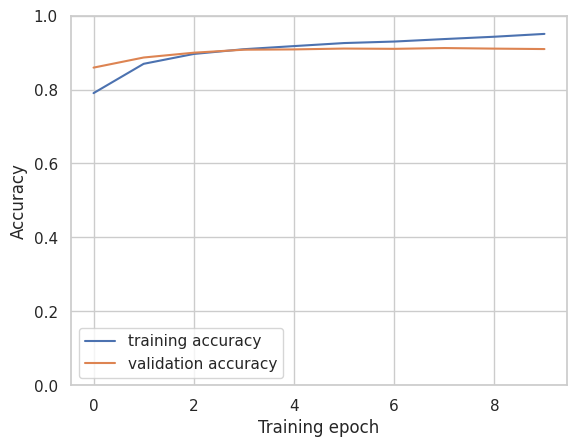

In [23]:
cnn = Sequential()
cnn.add(Embedding(embedding_matrix.shape[0],
                 embedding_matrix.shape[1],
                 weights = [embedding_matrix],
                 input_shape = (X_train_nn.shape[1],)))
cnn.add(Conv1D(40, 5, padding = 'valid', strides = 1, activation = 'relu'))
cnn.add(Dropout(0.3))
cnn.add(GlobalMaxPooling1D()) 
cnn.add(Dropout(0.3))
cnn.add(Dense(3, activation = 'softmax'))
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(patience = 2, monitor = 'val_loss')
history = cnn.fit(X_train_nn, y_train_nn, validation_split = 0.3, epochs = 30, callbacks = [early_stopping],
                  batch_size = 200, verbose = False)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(train_acc, label = 'training accuracy')
plt.plot(val_acc, label = 'validation accuracy')
plt.legend(loc = 0)
plt.xlabel('Training epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
print('training accuracy:', train_acc[-1])
print('validation accuracy:', val_acc[-1])

## Evaluation

We can see from the graph that after training epoch 2, the rate of growth of the validation accuracy stagnates, which suggests that if we ran the CNN for more than 10 iterations, we may start to see the model overfitting to the training data.
We can see that both the bias and the variance are roughly 5%, which is quite large for a classifier which could foreseeably analyze thousands of tweets. However, the variance can be decreased by increasing the size of the dataset, which could feasibly be very large given the ready availability of tweets. We can also make this neural network much deeper, which would decrease the bias but increase the variance.

# Given user name of twitter account, return how many offensive/hate crime posts out of last 1000

In [24]:
# THIS SECTION WILL NOT WORK IN LINUX ONE - DOWNLOAD THE FOLDERS AND RUN THIS
# refer to https://github.com/JustAnotherArchivist/snscrape/issues/996 for the reason behind the error (easily fixed if using Tweepy instead, but that is paid)
# (can't show output since my computer is near death atm)

import snscrape.modules.twitter as sntwitter



replace_user = lambda tweet: re.sub(r'(@\w+\s*)', r'TWITTER_HANDLE ', tweet)
clean_tweet = lambda tweet: re.sub(r'#|&|\(|\)|\"|(https?://\S*)|(�\S*\d*)|(128\d{3})|(_*UNDEF)',
                      ' ', tweet)

def tweet_rater(tweet):
    tweet = clean_tweet(tweet)
    tweet_tokens = [token.lemma_ for token in nlp(tweet)]
    tweet = ' '.join(tweet_tokens)
    x_vect = tokenizer.texts_to_sequences([tweet])
    x_vect = pad_sequences(x_vect, maxlen = max_sequence_length, padding = 'post', truncating = 'post')
    probas = cnn.predict(x_vect)[0]
    rating = np.argmax(probas)
    return rating

x = sntwitter.TwitterProfileScraper('elonmusk').get_items()
i = 0
offensive = 0
hatecrime = 0
good = 0
for i, elem in enumerate(x):
    try:
        if i > 1000:
            break
        if tweet_rater(elem.content) == 0:
            good += 1
        elif tweet_rater(elem.content) == 1:
            offensive += 1
        else:
            hatecrime += 1
    except Exception:
        break

print(f'Out of the past 1000 tweets, {good} were good, {offensive} were offensive, and {hatecrime} constitute a hatecrime.')
    

Error retrieving https://twitter.com/i/api/graphql/fn9oRltM1N4thkh5CVusPg/UserTweetsAndReplies?variables=%7B%22userId%22%3A44196397%2C%22count%22%3A100%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_translatable_rweb_tweet_is_translatable_enabled%22%3Atrue%2C%22view_counts_everywhere_api_enabled%22%3Atrue%2C%22longform_not

ScraperException: 4 requests to https://twitter.com/i/api/graphql/fn9oRltM1N4thkh5CVusPg/UserTweetsAndReplies?variables=%7B%22userId%22%3A44196397%2C%22count%22%3A100%2C%22includePromotedContent%22%3Atrue%2C%22withCommunity%22%3Atrue%2C%22withVoice%22%3Atrue%2C%22withV2Timeline%22%3Atrue%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_translatable_rweb_tweet_is_translatable_enabled%22%3Atrue%2C%22view_counts_everywhere_api_enabled%22%3Atrue%2C%22longform_notetweets_consumption_enabled%22%3Atrue%2C%22tweet_awards_web_tipping_enabled%22%3Afalse%2C%22freedom_of_speech_not_reach_fetch_enabled%22%3Atrue%2C%22standardized_nudges_misinfo%22%3Atrue%2C%22tweet_with_visibility_results_prefer_gql_limited_actions_policy_enabled%22%3Afalse%2C%22interactive_text_enabled%22%3Atrue%2C%22responsive_web_text_conversations_enabled%22%3Afalse%2C%22longform_notetweets_rich_text_read_enabled%22%3Atrue%2C%22longform_notetweets_inline_media_enabled%22%3Afalse%2C%22responsive_web_enhance_cards_enabled%22%3Afalse%7D failed, giving up.